In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

![](https://emerginggrowth.com/wp-content/uploads/2021/05/Health-Tech-Dr.jpg)

**Business Objective:**

The business objective of this project is to classify patient condition using drug review, namely Depression, High Blood Pressure, and Type 2 Diabetes. The goal is to understand the effectiveness of drugs for specific conditions and their potential side effects by analyzing patient reviews, ratings, and useful counts. The insights gained from this analysis can be used to recommend suitable drugs for patients based on their condition and the experiences of other patients with similar conditions.

**Features:**

* DrugName (categorical): The name of the drug that the patient is reviewing. This feature will be used to group reviews by drug and analyze the effectiveness of each drug for specific conditions.
* Condition (categorical): The name of the condition that the patient is reviewing the drug for. This feature will be used to identify reviews related to Depression, High Blood Pressure, and Type 2 Diabetes.
* Review (text): The patient's review of the drug. This feature will be used to extract insights on the effectiveness and potential side effects of drugs for specific conditions.
* Rating (numerical): A 10-star patient rating reflecting overall patient satisfaction with the drug. This feature will be used to understand the level of patient satisfaction with different drugs for specific conditions.
* Date (date): The date on which the review was entered. This feature will be used to analyze trends over time in patient reviews and ratings.
* UsefulCount (numerical): The number of users who found the review useful. This feature will be used to identify reviews that are likely to be helpful in understanding the effectiveness and potential side effects of drugs for specific conditions.

**Note:**

* I have taken only 3 conditions out of 884 different conditions for my analysis, which are 'Depression','High Blood Pressure' and 'Diabetes Type2'.

In [9]:
# Importing Required Libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import nltk
import string
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,mean_squared_error
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
data = pd.read_csv('../resources/drugsComTrain_raw.csv')
data

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,31-May-15,125
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,1-Nov-11,34
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,15-Mar-14,35
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,19-Sep-15,79


In [11]:
# Define the conditions to keep
keep_conditions = ["Depression", "High Blood Pressure", "Diabetes, Type 2"]

# Filter the DataFrame to only keep the records with the specified conditions
df = data[data['condition'].isin(keep_conditions)]

df.drop(['uniqueID'],axis =1,inplace=True)

df.head()

,drugName,condition,review,rating,date,usefulCount
11,L-methylfolate,Depression,"""I have taken anti-depressants for years, with...",10,9-Mar-17,54
31,Sertraline,Depression,"""1 week on Zoloft for anxiety and mood swings....",8,7-May-11,3
44,Venlafaxine,Depression,"""my gp started me on Venlafaxine yesterday to ...",4,27-Apr-16,3
50,Dulaglutide,"Diabetes, Type 2","""Hey Guys, It&#039;s been 4 months since my l...",10,24-Oct-17,24
67,Effexor XR,Depression,"""This medicine saved my life. I was at my wits...",10,20-Jun-13,166


In [12]:
df.shape

(13944, 6)

In [13]:
df.describe()

,rating,usefulCount
count,13944.000000,13944.000000
mean,6.862952,45.737880
std,3.207061,51.782627
min,1.000000,0.000000
25%,4.000000,16.000000
50%,8.000000,31.000000
75%,10.000000,59.000000
max,10.000000,1291.000000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13944 entries, 11 to 161290
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   drugName     13944 non-null  object
 1   condition    13944 non-null  object
 2   review       13944 non-null  object
 3   rating       13944 non-null  int64 
 4   date         13944 non-null  object
 5   usefulCount  13944 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 762.6+ KB


# EDA AND DATA VISUALIZATION:

In [15]:
# Missing values
df.isnull().sum()

drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [16]:
df.duplicated().sum()

0

In [17]:
# Most popular drugs
# Top 20
df['drugName'].value_counts().nlargest(20)

Bupropion         549
Sertraline        459
Venlafaxine       437
Pristiq           418
Desvenlafaxine    414
Citalopram        388
Escitalopram      380
Vortioxetine      345
Duloxetine        328
Vilazodone        315
Lexapro           306
Cymbalta          303
Fluoxetine        302
Viibryd           285
Zoloft            281
Liraglutide       270
Lisinopril        264
Victoza           255
Trintellix        243
Dulaglutide       231
Name: drugName, dtype: int64

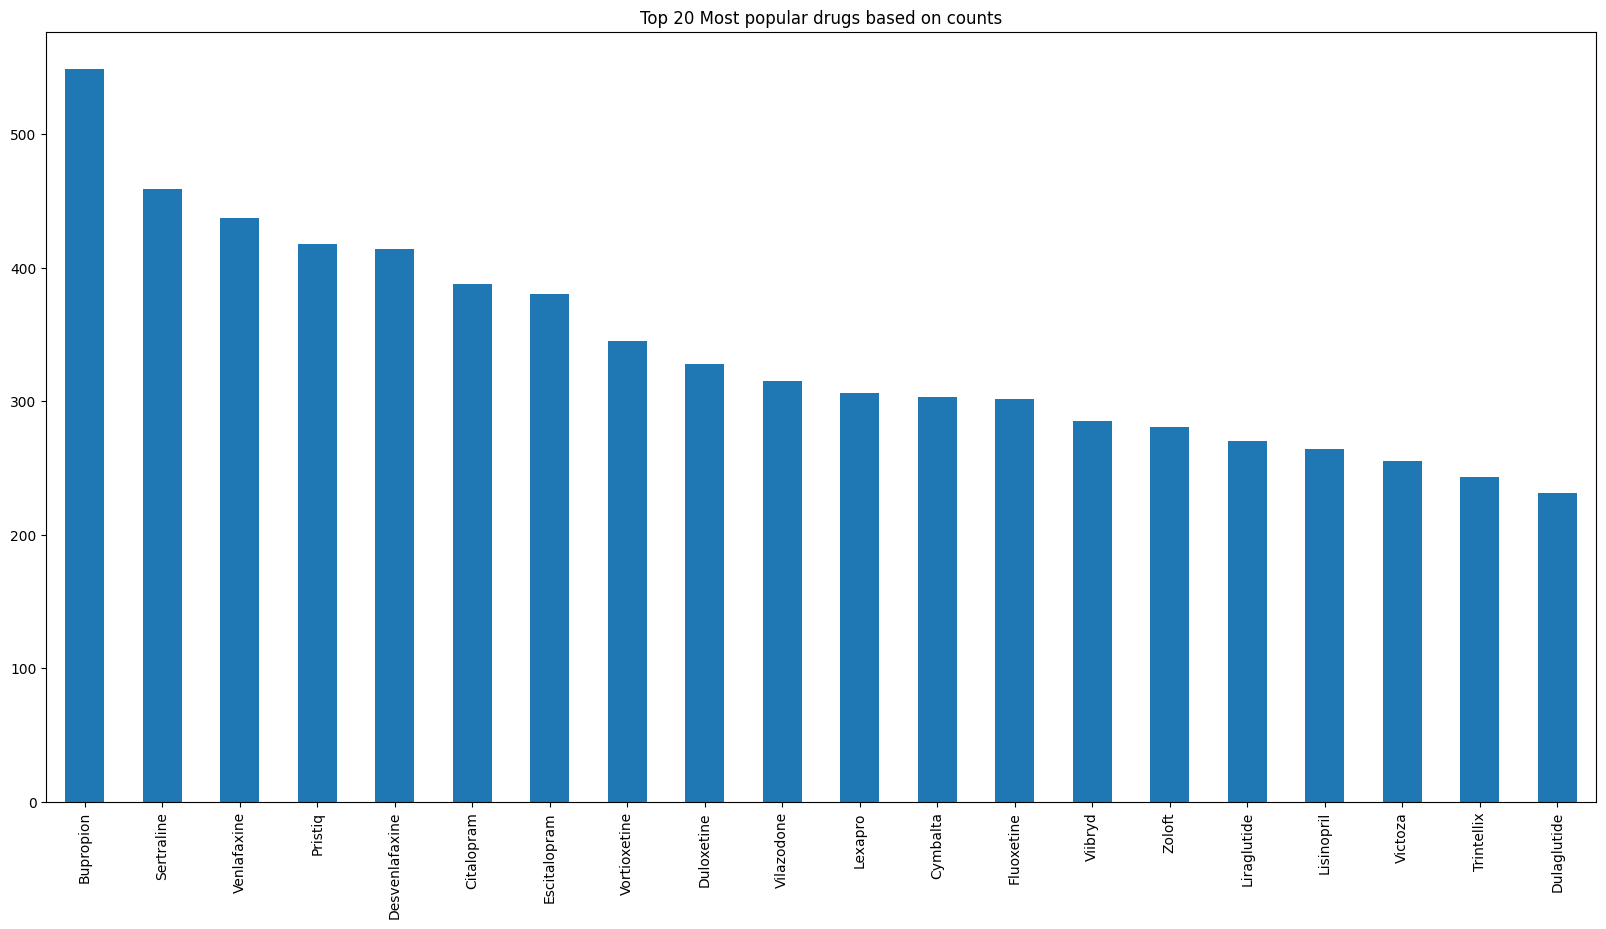

In [18]:
# Top 20 Drugs(MOst Popular)
plt.figure(figsize=(20,10))
df['drugName'].value_counts().nlargest(20).plot(kind='bar')
plt.title('Top 20 Most popular drugs based on counts')
plt.show()

<Figure size 1500x1000 with 0 Axes>

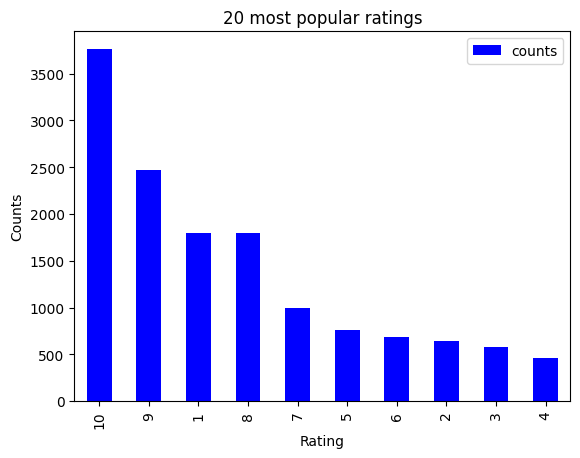

In [19]:
# Grouping the data by rating and count the frequency of each rating
rating_counts = df.groupby('rating').size().reset_index(name='counts')

# Sort the data by the frequency of each rating
rating_counts = rating_counts.sort_values(by='counts',ascending=False)

# Plot a bar chart of the 20 most popular ratings
plt.figure(figsize=(15,10))
rating_counts[:20].plot.bar(x='rating',y='counts',color='blue')
plt.xlabel('Rating')
plt.ylabel('Counts')
plt.title('20 most popular ratings')
plt.show()

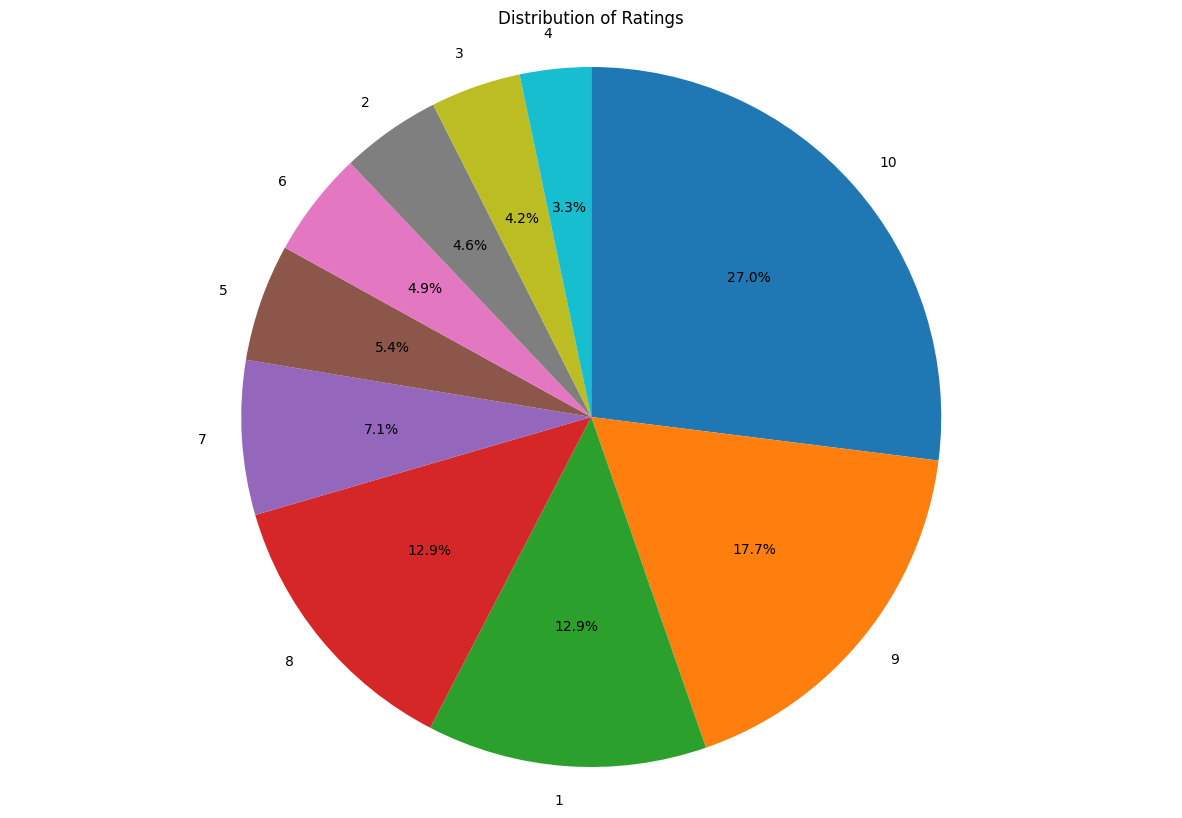

In [20]:
# Plot a pie chart of the distribution of ratings
plt.figure(figsize=(15,10))
plt.pie(rating_counts['counts'], labels=rating_counts['rating'], startangle=90, counterclock=False, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Distribution of Ratings')
plt.show()

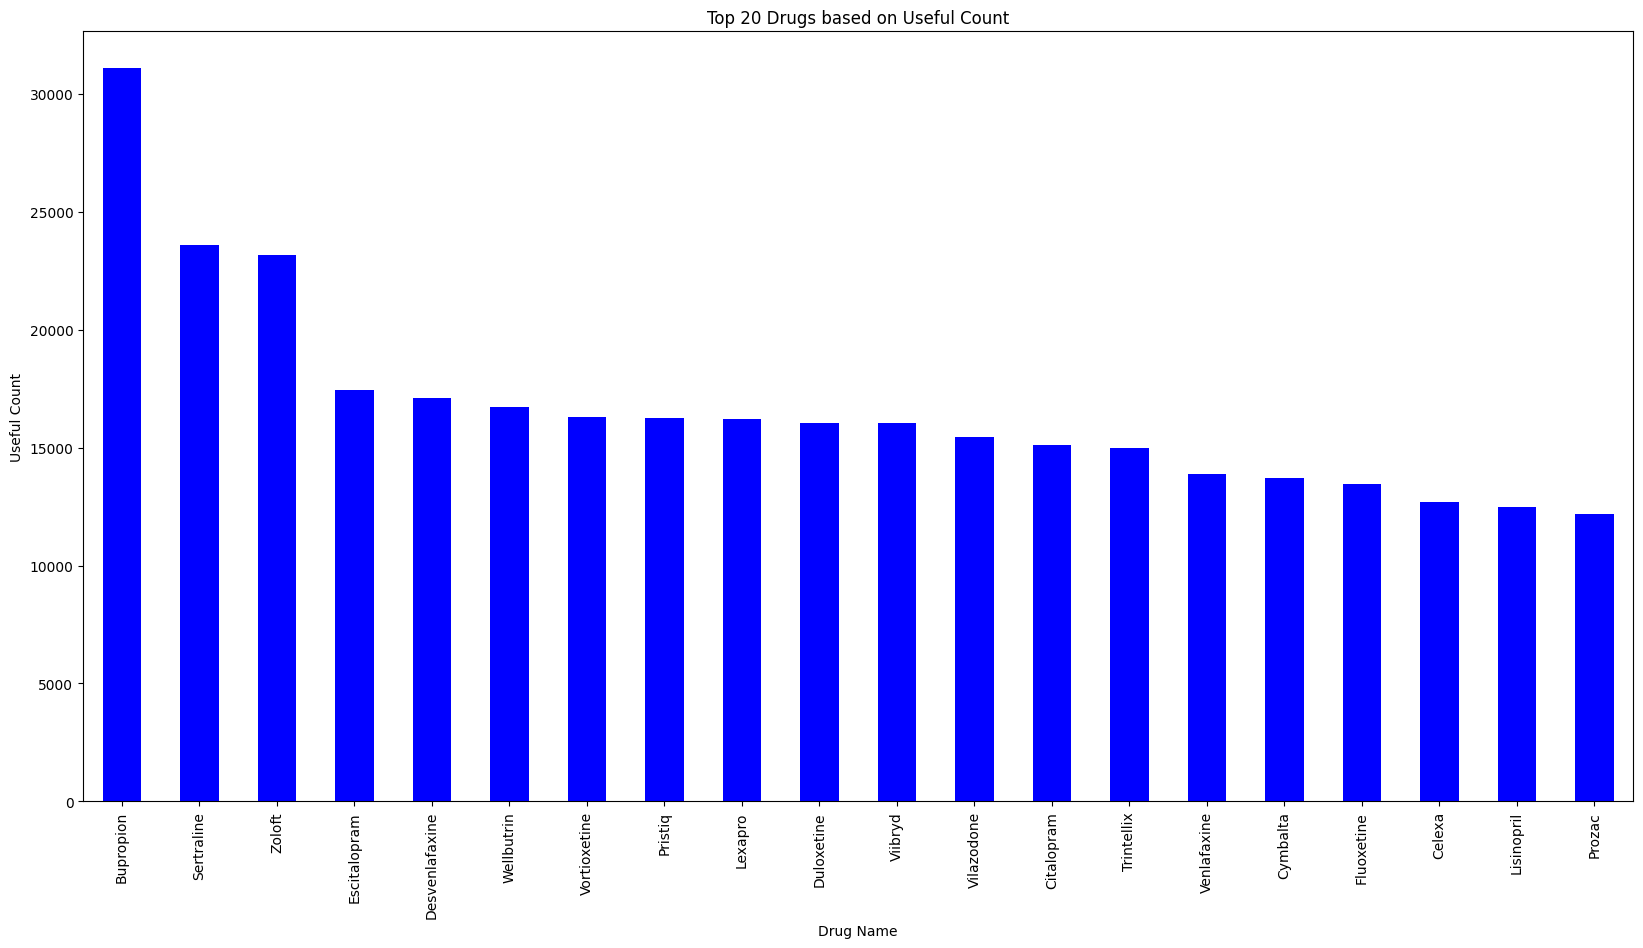

In [21]:
# Get the 20 most popular drugs based on usefulCount
plt.figure(figsize=(20,10))
top_20_drugs = df.groupby('drugName')['usefulCount'].sum().sort_values(ascending=False).head(20)

# Plot the bar plot
top_20_drugs.plot(kind='bar', color='blue')
plt.xlabel('Drug Name')
plt.ylabel('Useful Count')
plt.title('Top 20 Drugs based on Useful Count')
plt.xticks(rotation=90)
plt.show()

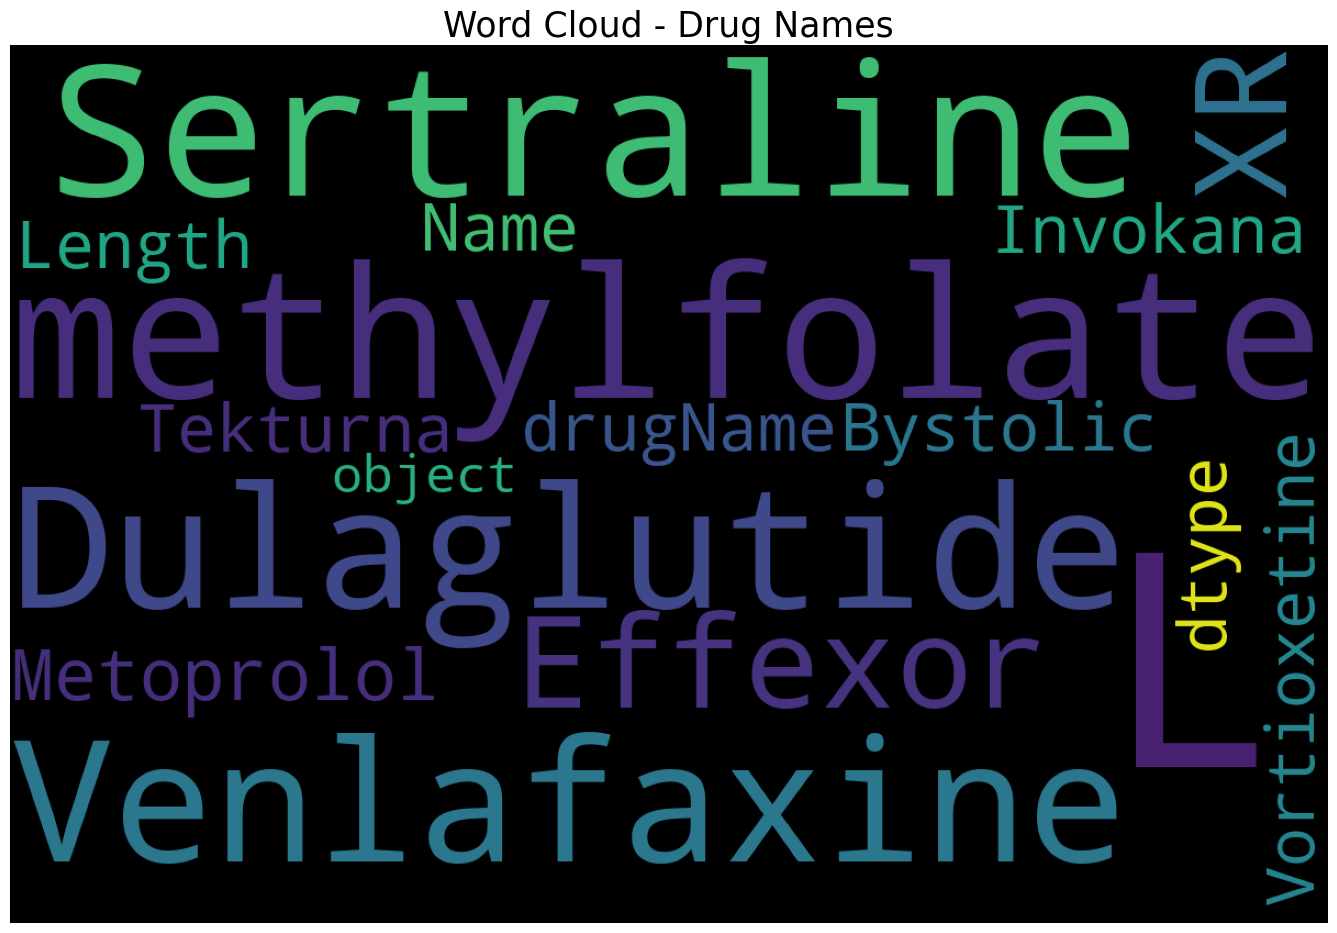

In [22]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords = stopwords, width = 1200, height = 800).generate(str(df['drugName']))

plt.rcParams['figure.figsize'] = (17, 17)
plt.title('Word Cloud - Drug Names', fontsize = 25)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

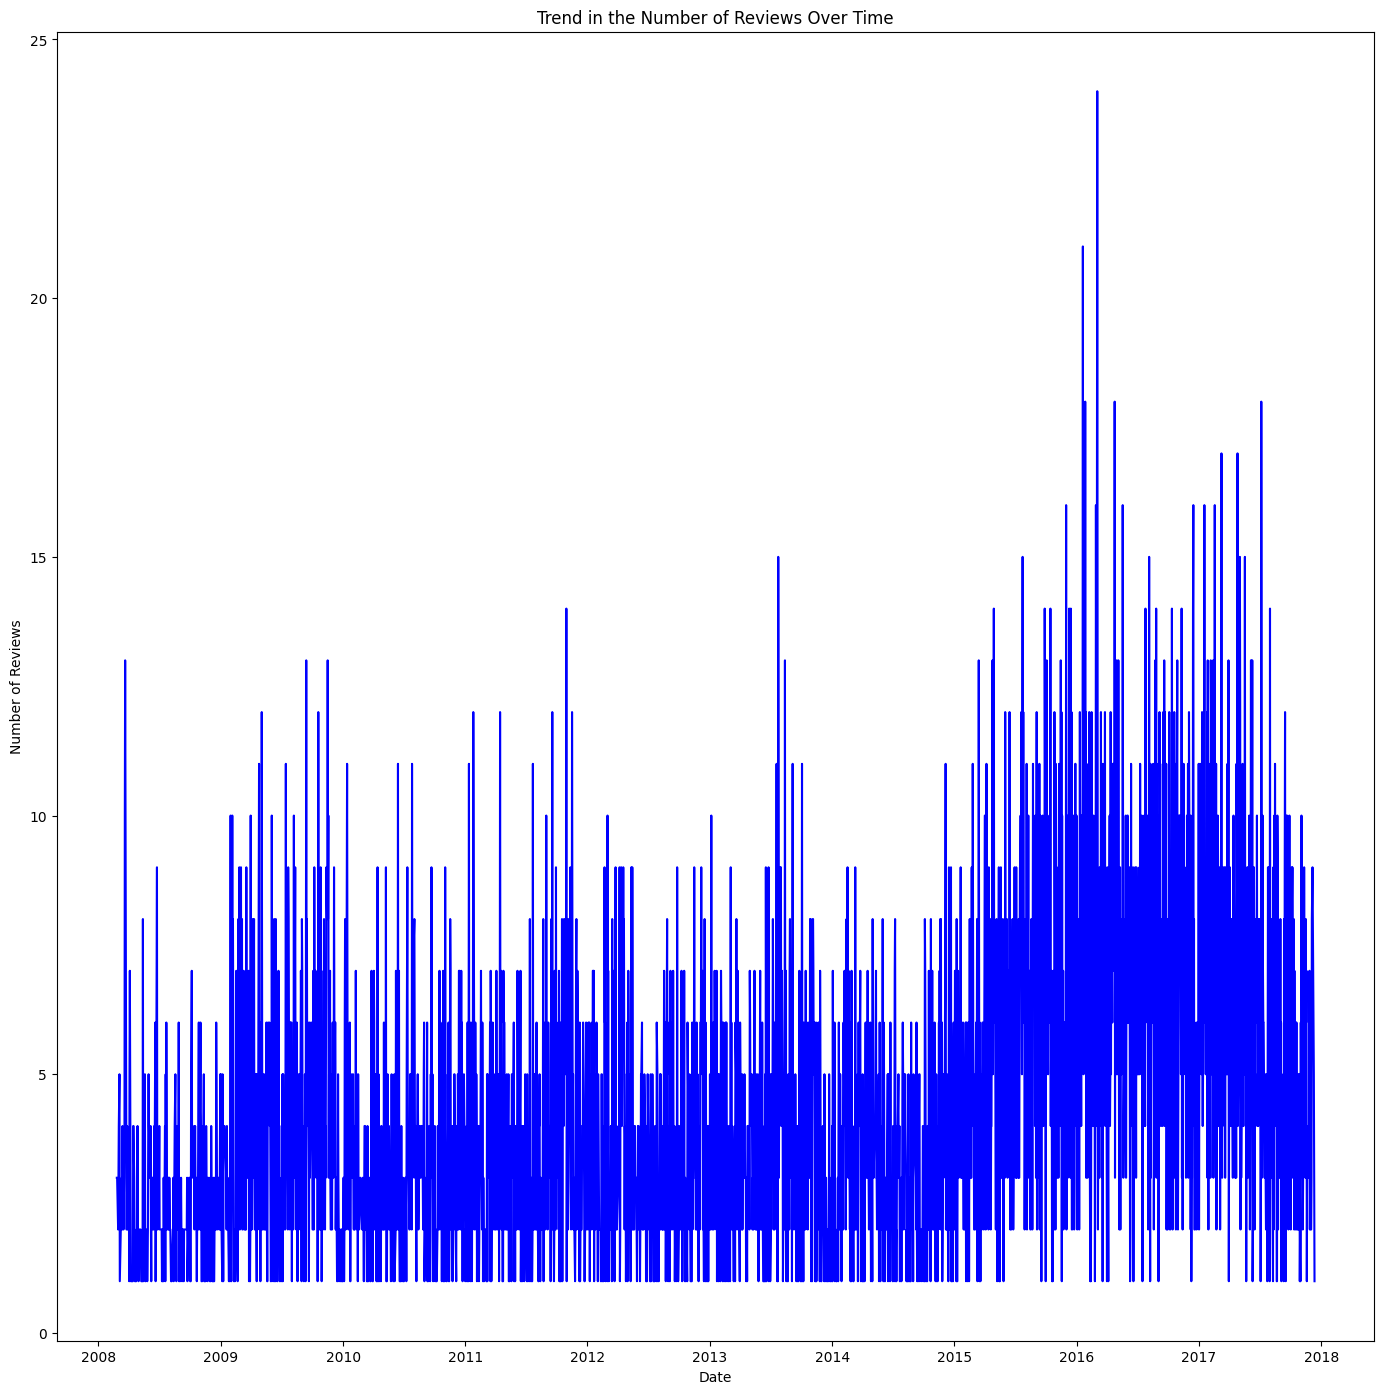

In [23]:
# Convert the date column to a datetime format
df['date'] = pd.to_datetime(df['date'])

# Group the data by date and count the number of reviews for each date
reviews_per_date = df.groupby(df['date'].dt.date).size().reset_index(name='counts')

# Plot a line chart of the trend in the number of reviews over time
plt.plot(reviews_per_date['date'], reviews_per_date['counts'], color='blue')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.title('Trend in the Number of Reviews Over Time')
plt.show()

## Interpretation:

* 1-Improved Accessibility: There might have been improvements in the accessibility of the drug, either through increased availability or decreased cost, which led to an increase in the number of patients using the drug and writing reviews.

* 2-Increased Use of Online Platforms: The increase in the use of online platforms for reviewing drugs and conditions might have contributed to the increase in the number of reviews from 2015 onwards.

* 3-Changes in Marketing Strategies: The drug manufacturer or the healthcare industry might have changed their marketing strategies to increase the visibility of the drug, which led to an increase in the number of patients using the drug and writing reviews.

## Feature Engineering/ Data Preprocessing:

In [24]:
def clean_review(review):
    # Convert to lowercase
    review = review.lower()
    
    # Remove punctuation
    review = review.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize the review
    tokens = nltk.word_tokenize(review)
    
    # Remove stop words
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    
    # Join the cleaned tokens back together
    cleaned_review = ' '.join(tokens)
    
    return cleaned_review

In [25]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [26]:
df['review'] = df['review'].apply(lambda x: clean_review(x))
df

,drugName,condition,review,rating,date,usefulCount
11,L-methylfolate,Depression,taken antidepressants years improvement mostly...,10,2017-03-09,54
31,Sertraline,Depression,1 week zoloft anxiety mood swings take 50mg mo...,8,2011-05-07,3
44,Venlafaxine,Depression,gp started venlafaxine yesterday help depressi...,4,2016-04-27,3
50,Dulaglutide,"Diabetes, Type 2",hey guys it039s 4 months since last post wante...,10,2017-10-24,24
67,Effexor XR,Depression,medicine saved life wits end antidepressants r...,10,2013-06-20,166
...,...,...,...,...,...,...
161251,Metoprolol,High Blood Pressure,fourth blood pressure pill feels like partly w...,4,2009-07-15,39
161258,Bystolic,High Blood Pressure,bystolic feet arms numb blood sugars became se...,1,2009-07-18,25
161278,Invokana,"Diabetes, Type 2",got diagnosed type 2 doctor prescribed invokan...,9,2015-10-23,47
161286,Vortioxetine,Depression,third med i039ve tried anxiety mild depression...,2,2016-07-17,33


* The importance of the date feature depends on the business problem and the type of model being used. In some cases, the date feature may be important in identifying patterns and trends over time. For example, if you are building a time-series model, the date feature would be an important input for the model. However, in other cases, the date feature may not be as relevant. For instance, if you are building a model to predict the rating based on the review, the date feature may not have a significant impact on the model's predictions.

In [27]:
df.drop(['date'],axis=1,inplace=True)

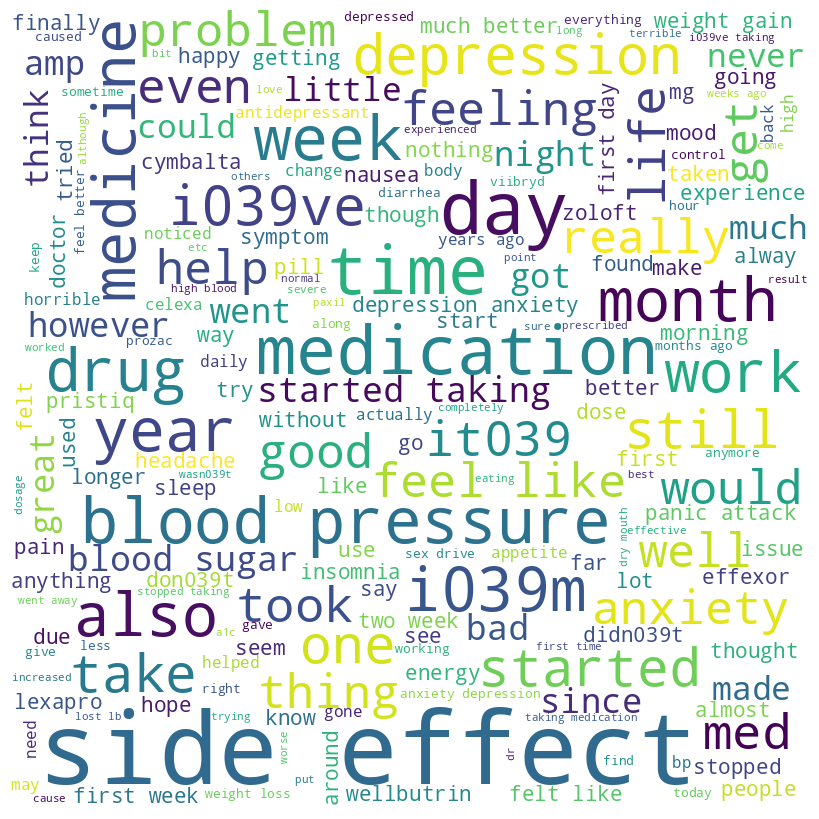

In [28]:
# Get the stopwords as a list
stopwords = list(stopwords.words('english'))

# Join all the reviews into a single string
reviews_text = " ".join(review for review in df.review)

# Generate the wordcloud
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10).generate(reviews_text)

# Plot the wordcloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

In [29]:
df

,drugName,condition,review,rating,usefulCount
11,L-methylfolate,Depression,taken antidepressants years improvement mostly...,10,54
31,Sertraline,Depression,1 week zoloft anxiety mood swings take 50mg mo...,8,3
44,Venlafaxine,Depression,gp started venlafaxine yesterday help depressi...,4,3
50,Dulaglutide,"Diabetes, Type 2",hey guys it039s 4 months since last post wante...,10,24
67,Effexor XR,Depression,medicine saved life wits end antidepressants r...,10,166
...,...,...,...,...,...
161251,Metoprolol,High Blood Pressure,fourth blood pressure pill feels like partly w...,4,39
161258,Bystolic,High Blood Pressure,bystolic feet arms numb blood sugars became se...,1,25
161278,Invokana,"Diabetes, Type 2",got diagnosed type 2 doctor prescribed invokan...,9,47
161286,Vortioxetine,Depression,third med i039ve tried anxiety mild depression...,2,33


# MODEL BUILDING:

In [30]:
df["rating"] = df["rating"].astype(int)

In [43]:
# Create the feature matrix
vectorizer = TfidfVectorizer(lowercase=True, stop_words="english")
reviews = vectorizer.fit_transform(df["review"])
print(reviews.shape)
print(df['condition'])

(13944, 18492)
11                 Depression
31                 Depression
44                 Depression
50           Diabetes, Type 2
67                 Depression
                 ...         
161251    High Blood Pressure
161258    High Blood Pressure
161278       Diabetes, Type 2
161286             Depression
161290    High Blood Pressure
Name: condition, Length: 13944, dtype: object


In [32]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(reviews, df["condition"], test_size=0.25, random_state=42)

## Model-1 Logistic Regression:

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
# Train the model
model = LogisticRegression(multi_class="ovr")
model.fit(X_train, y_train)

LogisticRegression(multi_class='ovr')

In [35]:
# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

         Depression       0.93      0.99      0.96      2257
   Diabetes, Type 2       0.98      0.91      0.94       627
High Blood Pressure       0.96      0.79      0.87       602

           accuracy                           0.94      3486
          macro avg       0.96      0.90      0.92      3486
       weighted avg       0.94      0.94      0.94      3486



In [36]:
# Use the model to make predictions for new data
new_review = ["This drug is amazing, it really helped me with my condition!"]
new_review = vectorizer.transform(new_review)
new_condition = model.predict(new_review)[0]
print("Predicted Condition:", new_condition)

Predicted Condition: Depression


## Model-2 Random Forest:

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
model2 = RandomForestClassifier()
model2.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
y_pred = model2.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
new_review = ["This drug is amazing, it really helped me with my condition!"]
new_review = vectorizer.transform(new_review)
new_condition = model2.predict(new_review)[0]
print("Predicted Condition:", new_condition)

## Model-3 Support Vector Machine:

In [ ]:
from sklearn.svm import SVC

In [ ]:
# Train the model
model3 = SVC()
model3.fit(X_train, y_train)

In [ ]:
# Evaluate the model
y_pred = model3.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
# Use the model to make predictions for new data
new_review = ["This drug is amazing, it really helped me with my condition!"]
new_review = vectorizer.transform(new_review)
new_condition = model3.predict(new_review)[0]
print("Predicted Condition:", new_condition)

## Model-4 Gradient Boosting:

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# Train the model
model4 = GradientBoostingClassifier()
model4.fit(X_train, y_train)

In [ ]:
# Evaluate the model
y_pred = model4.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
# Use the model to make predictions for new data
new_review = ["This drug is amazing, it really helped me with my condition!"]
new_review = vectorizer.transform(new_review)
new_condition = model4.predict(new_review)[0]
print("Predicted Condition:", new_condition)

## Model-5 Decision Tree:

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Train the model
model5 = DecisionTreeClassifier()
model5.fit(X_train, y_train)

In [ ]:
# Evaluate the model
y_pred = model5.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
# Use the model to make predictions for new data
new_review = ["This drug is amazing, it really helped me with my condition!"]
new_review = vectorizer.transform(new_review)
new_condition = model5.predict(new_review)[0]
print("Predicted Condition:", new_condition)

* Based on accuracy score , I have selected Support Vector Machine as best model among all the models I built.

# Drug Recommendation based on Ratings:

In [ ]:
drug_ratings = df[df["condition"] == new_condition].groupby("drugName")["rating"].mean()
recommended_drugs = drug_ratings.nlargest(5).index.tolist()
print("Recommended Drugs based on ratings only:")
for i, drug in enumerate(recommended_drugs):
    print(i+1, drug)

**Project Summary:**

* The project aims to classify patient's condition based on the reviews they provide.
* The data was cleaned by removing stop words and performing normalization, and the date feature was excluded as it was deemed unhelpful for building the model.
* To convert the review text into numerical data, the TF-IDF vectorizer was employed, and several models, including Logistic Regression, Random Forest, SVM, Gradient Boosting, and Decision Tree, were constructed, using the patient's condition as the dependent variable and the review as the independent variable.
* The SVM model was selected as the best model based on the evaluation metrics, which demonstrated its superior accuracy.
* The project also recommended 5 popular drugs based on their ratings; however, it was noted that individual drug effects may vary, and the recommendations should be considered general in nature.

***Conclusion:***

The project successfully predicted patient conditions based on drug reviews, and the insights gained can be used to recommend suitable drugs for patients based on their condition and the experiences of other patients with similar conditions. The project's findings provide valuable information to healthcare providers and patients alike in making informed decisions regarding drug usage.